# Final Embedding

## Purpose
The purpose of this step is to recalculate the embedding coordinates using consensus clustering labels and the Cluster Enriched Features (CEF) of each cluster.

## Input
- HVF adata file.
- Consensus cluster labels

## Output
- HVF adata file with updated embedding coordinates.

## Import

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
from ALLCools.clustering import cluster_enriched_features, significant_pc_test, log_scale, balanced_pca, tsne
from ALLCools.plot import categorical_scatter

In [2]:
sns.set_context(context='notebook', font_scale=1.3)

## Parameters

In [3]:
cell_metadata_path = 'CellMetadata.PassQC.csv.gz'
cluster_adata_path = 'adata.with_coords.h5ad'
ch_adata_path = 'mCH.HVF.h5ad'
cg_adata_path = 'mCG.HVF.h5ad'

# Cluster Enriched Features analysis
top_n=200
alpha=0.05
stat_plot=True

# you may provide a pre calculated cluster version. 
# If None, will perform basic clustering using parameters below.
cluster_col = 'L1'
p_cutoff = 0.1

## Load Data

In [4]:
adata = anndata.read_h5ad(cluster_adata_path)
ch_adata = anndata.read_h5ad(ch_adata_path)
cg_adata = anndata.read_h5ad(cg_adata_path)

## Cluster Enriched Features (CEF)

### mCH

Found 26 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 3027 unique features


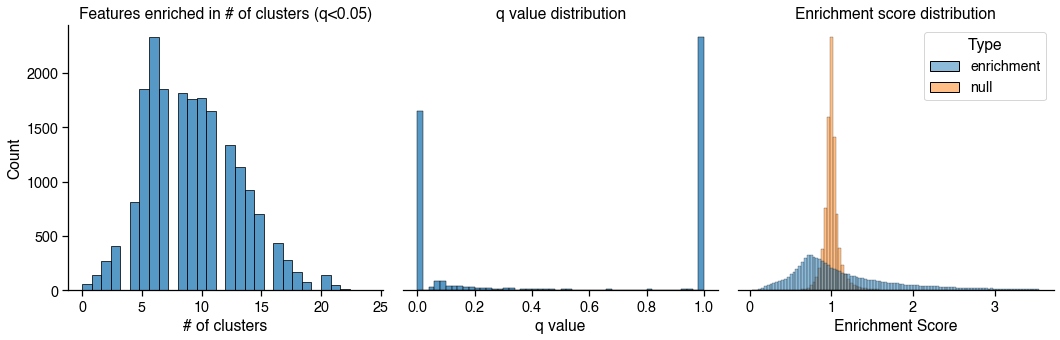

In [5]:
ch_adata.obs[cluster_col] = adata.obs[cluster_col]
cluster_enriched_features(ch_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

### mCG

Found 26 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 2715 unique features


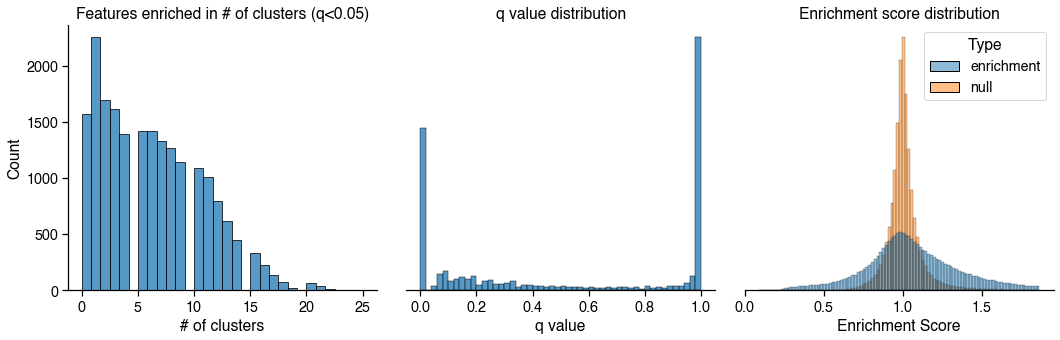

In [6]:
cg_adata.obs[cluster_col] = adata.obs[cluster_col]
cluster_enriched_features(cg_adata,
                          cluster_col=cluster_col,
                          top_n=top_n,
                          alpha=alpha,
                          stat_plot=True)

## Save AnnData

In [7]:
# save adata
ch_adata.write_h5ad(ch_adata_path)
cg_adata.write_h5ad(cg_adata_path)

# save CEF ids
with open(f'{cluster_col}_enriched_features.mCH.txt', 'w') as f:
    features = ch_adata.var_names[ch_adata.var[f'{cluster_col}_enriched_features']]
    f.write('\n'.join(features))
with open(f'{cluster_col}_enriched_features.mCG.txt', 'w') as f:
    features = cg_adata.var_names[cg_adata.var[f'{cluster_col}_enriched_features']]
    f.write('\n'.join(features))

## PCA

### mCH

In [8]:
# using Cluster Enriched Features
ch_adata = ch_adata[:, ch_adata.var[f'{cluster_col}_enriched_features']].copy()
# scale
log_scale(ch_adata)
# PCA
balanced_pca(ch_adata, groups=cluster_col)
# Select significant PCs
ch_n_components = significant_pc_test(ch_adata, p_cutoff=p_cutoff)

52 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (16985, 200) to (16985, 52)


### mCG

In [9]:
# using Cluster Enriched Features
cg_adata = cg_adata[:, cg_adata.var[f'{cluster_col}_enriched_features']].copy()
# scale
log_scale(cg_adata)
# PCA
balanced_pca(cg_adata, groups=cluster_col)
# Select significant PCs
cg_n_components = significant_pc_test(cg_adata, p_cutoff=p_cutoff)

22 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (16985, 200) to (16985, 22)


### Concatenate

In [10]:
ch_pcs = ch_adata.obsm['X_pca'][:, :ch_n_components]
cg_pcs = cg_adata.obsm['X_pca'][:, :cg_n_components]

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])
adata.obsm['X_pca'] = total_pcs

## Manifold Learning

In [11]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata

### tSNE

In [12]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(adata, 'tsne')

AnnData object with n_obs × n_vars = 16985 × 3102
    obs: 'leiden', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'leiden_enriched_features', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

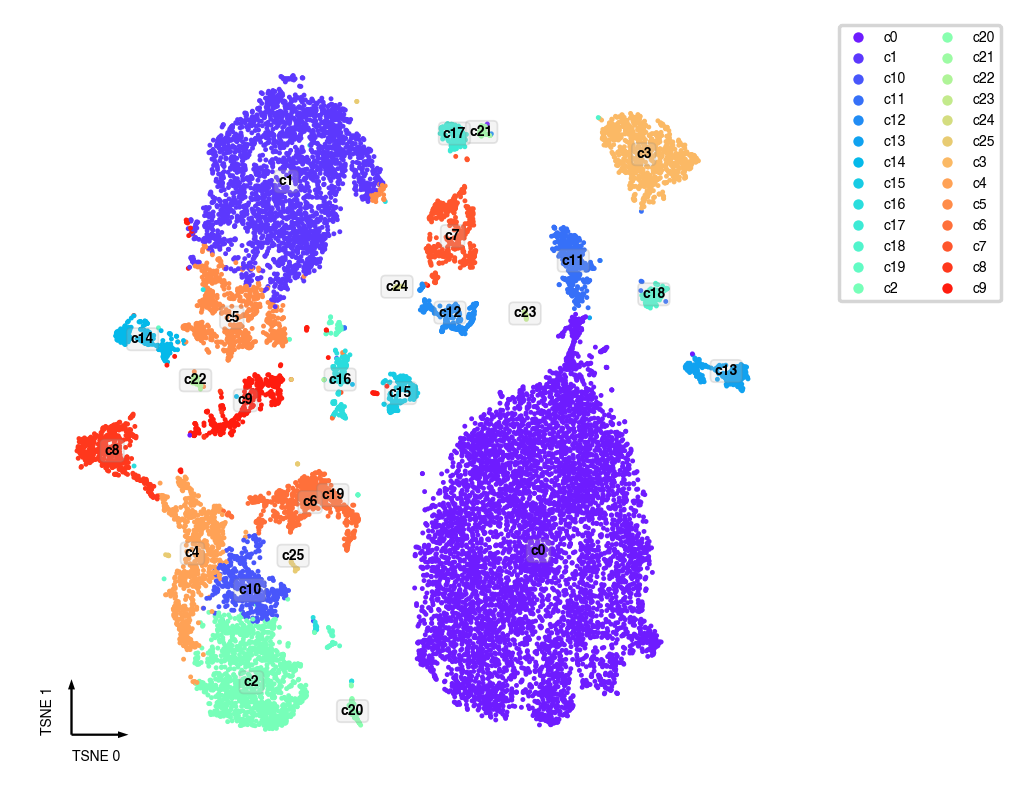

In [13]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='tsne',
                        hue=cluster_col,
                        show_legend=True,
                        text_anno=cluster_col,
                        s=2,
                        max_points=None)

### UMAP

In [14]:
sc.pp.neighbors(adata)
try:
    sc.tl.paga(adata, groups=cluster_col)
    sc.pl.paga(adata, plot=False)
    sc.tl.umap(adata, init_pos='paga')
except:
    sc.tl.umap(adata)
dump_embedding(adata, 'umap')

AnnData object with n_obs × n_vars = 16985 × 3102
    obs: 'leiden', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'leiden_enriched_features', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'leiden_sizes', 'neighbors', 'paga', 'umap', 'L1_sizes'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

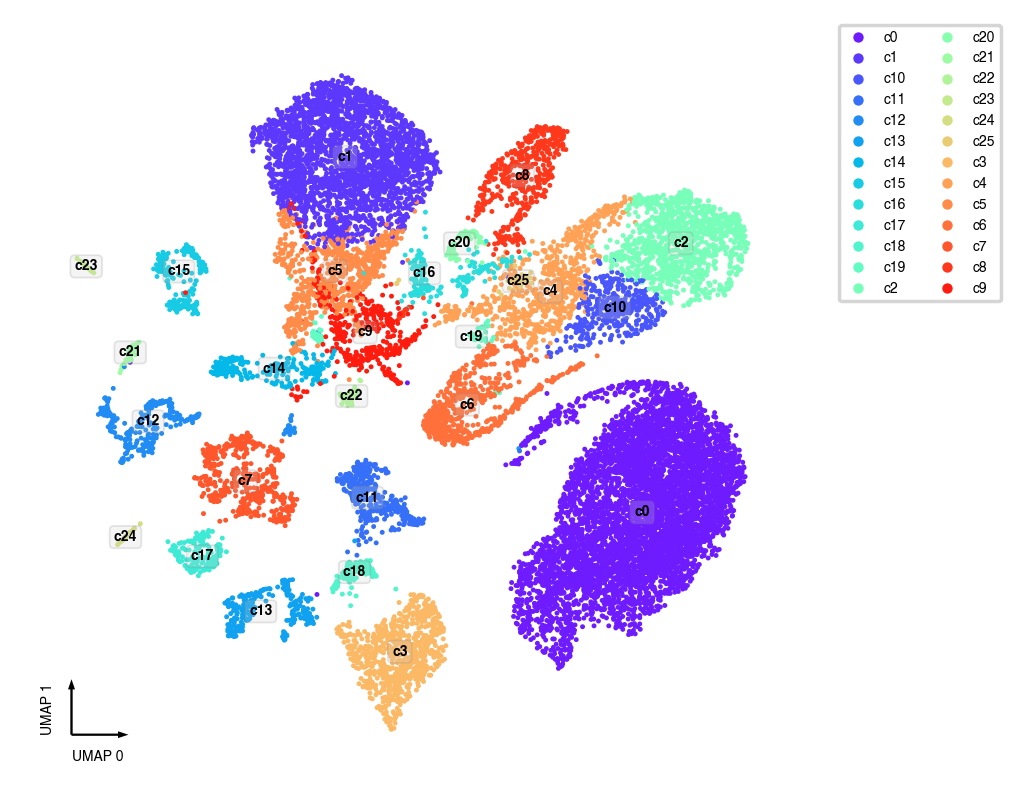

In [15]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata.obs,
                        ax=ax,
                        coord_base='umap',
                        hue=cluster_col,
                        show_legend=True,
                        text_anno=cluster_col,
                        s=2,
                        max_points=None)

## Save

In [16]:
adata.write_h5ad('adata.with_coords.h5ad')
adata

AnnData object with n_obs × n_vars = 16985 × 3102
    obs: 'leiden', 'mCHFrac', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno'
    var: 'chrom', 'bin_start', 'bin_end', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'leiden_enriched_features', 'mean', 'std'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'leiden_sizes', 'neighbors', 'paga', 'umap', 'L1_sizes'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [17]:
# save final clustering result table
cell_meta = pd.read_csv(cell_metadata_path, index_col=0)
final_result = pd.concat([cell_meta, adata.obs], axis=1, sort=True)
final_result.to_csv(f'{cluster_col}.ClusteringResults.csv.gz')
final_result.head()

,AllcPath,mCCCFrac,mCGFrac,mCGFracAdj,mCHFrac,mCHFracAdj,FinalReads,InputReads,MappedReads,DissectionRegion,...,Sample,leiden,mCHFrac,tsne_0,tsne_1,umap_0,umap_1,L1,L1_proba,CellTypeAnno
10E_M_0,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.008198,0.822633,0.821166,0.041640,0.033718,1626504.0,4407752,2892347.0,10E,...,10E_190625,14,0.041640,4.422312,32.817532,-2.776936,0.910859,c7,0.718517,MGE-Sst
10E_M_1,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006019,0.743035,0.741479,0.024127,0.018218,2009998.0,5524084,3657352.0,10E,...,10E_190625,8,0.024127,-44.612333,-33.222181,9.975079,10.775970,c4,0.724762,CA3
10E_M_10,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006569,0.750172,0.748520,0.027665,0.021235,1383636.0,3455260,2172987.0,10E,...,10E_190625,8,0.027665,-43.991445,-28.466108,9.412707,9.894364,c4,0.828400,CA3
10E_M_101,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.006353,0.760898,0.759369,0.026547,0.020323,2474670.0,7245482,4778768.0,10E,...,10E_190625,8,0.026547,-40.476595,-17.625580,7.975397,7.598768,c4,0.714865,CA3
10E_M_102,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005409,0.752980,0.751637,0.019497,0.014164,2430290.0,7004754,4609570.0,10E,...,10E_190625,23,0.019497,-26.758905,16.534931,-0.437397,10.436956,c5,0.503633,CA1
